# Homology of hemoglobin subunit alpha

This notebook provides an example application of different sequence-related methods from *Biotite*.
Here proteins homologous to the alpha subunit of human hemoglobin should be identified, aligned using a multiple sequence alignment and their conservation around the heme binding site is going to be analyzed and visualized. 

## Alignment search in SwissProt database

For the purpose of the example homologous proteins are searched in the curated Swiss-Prot database.
For efficient search of high scoring alignments a heuristic method similar to BLAST is chosen.
This method uses multiple steps with increasing accuracy, but also computation time requirements.
The higher efficiency compared to a rigorous alignment stems from filtering:
In each step the number of possible alignment candidates, so called hits, is reduced, so that in the time
consuming steps only a few hits need to be checked.

In [1]:
from io import BytesIO
import requests
import gzip
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import biotite.sequence as seq
import biotite.sequence.align as align
import biotite.sequence.io.fasta as fasta
import biotite.sequence.graphics as graphics
import biotite.database.uniprot as uniprot

matplotlib.rcParams['figure.dpi'] = 80

# Some constants required for the multi-step alignment search
K = 6
PATTERN = "1101010011"
THRESHOLD_PER_POS = 5
X_DROP = 20
SCORE_THRESHOLD = 100
MATRIX = "BLOSUM62"
GAP_PENALTY = (-11, -1)
MAX_GAPS = 20

### Data extraction

Initially, the complete Swiss-Prot database is downloaded. This curated sequence data subset from the UniProt database is rather small, making it ideal for this demonstration purpose.
From the downloaded FASTA file the sequences with their corresponding gene names and UniProt IDs are extracted.
Proteins that stem from viruses or are uncharacterized are filtered out.
Finally, the sequence of human hemoglobin subunit alpha, the query sequence for this alignment search, is also fetched from the UniProt database.

In [2]:
response = requests.get(
    "https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/complete/uniprot_sprot.fasta.gz"
)

uniprot_ids = []
gene_names = []
db_sequences = []

with gzip.open(BytesIO(response.content), "rt") as gz_file:
    for i, (header, seq_str) in enumerate(fasta.FastaFile.read_iter(gz_file)):
        uniprot_id = header.split("|")[1]
        gene_name = header.split("|")[2].split()[0]
        
        if len(seq_str) < len(PATTERN):
            # Sequence must be longer than k-mer pattern to generate at least one k-mer
            continue
        if "Uncharacterized protein" in header:
            # Protein must be characterized
            continue
        if "virus" in header:
            # Exclude viruses
            continue
        
        # Replace special amino acids by canonical substitute to be compatible with alphabet
        sequence = seq.ProteinSequence(seq_str.replace("U", "C").replace("O", "K"))
        
        uniprot_ids.append(uniprot_id)
        gene_names.append(gene_name)
        db_sequences.append(sequence)

# The query sequence
hba_seq = fasta.get_sequence(fasta.FastaFile.read(uniprot.fetch("P69905", "fasta")))

### k-mer matching

The *k*-mers of a sequence, also called *words*, are all contiguous subsequences of length *k*.
A fast way to find similar regions between two sequences is finding *k*-mer matches in both sequences.
Therefore, *k*-mers are stored in a data structure called *k-mer* index table, that maps each *k-mer* to all positions, where it appears in a sequence.
This way the positions with equal *k*-mers can be simply looked up.
In the case of a real alignment software, the table can be reused for an arbitrary number of queries.

In this case two more techniques are applied to increase search sensitivity:
*Spaced* *k*-mers contain *'don't care'* positions and therefore allow for occasional mismatches between two sequence.
A score threshold allows also matching against *k*-mers with evolutionary similar amino acids in contrast to exclusively equal amino acids.

Usually regions with repeating sequence patterns are filtered out, since these can be lead to spurious high scoring alignments.
However, masking these regions with software such as *tantan* increases the runtime considerably.
Hence, it is omitted for the purpose of this notebook.

In [3]:
# BLOSUM62 matrix
matrix = align.SubstitutionMatrix(
    seq.ProteinSequence.alphabet, seq.ProteinSequence.alphabet, "BLOSUM62"
)
kmer_table = align.KmerTable.from_sequences(K, db_sequences, spacing=PATTERN)
similarity_rule = align.ScoreThresholdRule(matrix, K * THRESHOLD_PER_POS)
matches = kmer_table.match(
    hba_seq, similarity_rule
)

### Double hit strategy

To reduce the number of hits, *double hits* are required:
A double hit are two hit positions with some distance but without insertions/deletions between them.

In [4]:
diagonals = matches[:,2] - matches[:,0]

# Store the indices to the match array for each combination of SwissProt entry and diagonal
matches_for_diagonals = {}
for i, (ref_id, diag) in enumerate(zip(matches[:,1], diagonals)):
    if (ref_id, diag) not in matches_for_diagonals:
        matches_for_diagonals[(ref_id, diag)] = [i]
    else:
        matches_for_diagonals[(ref_id, diag)].append(i)

# Check for double hits, i.e. more than one match per ID + diagonal combination
# If a double hit exists, the first hit position is taken for the downstream alignment
double_hit_indices = [indices[0] for indices in matches_for_diagonals.values() if len(indices) > 1]
double_hits = matches[double_hit_indices]

### Ungapped alignments

In the next step a fast ungapped alignment is executed around each hit position.
This alignment uses an *X-drop* heuristic:
If the alignment score drops *X* below the highest score seen so far, it is improbable that another high scoring
alignment region follows after that - the alignment is terminated.
Only ungapped alignments with sufficient score proceed to the next step. 

In [5]:
ungapped_scores = np.array([
    align.align_local_ungapped(
        hba_seq, db_sequences[ref_id], matrix,
        seed=(i,j), threshold=X_DROP, score_only=True
    )
    for i, ref_id, j in double_hits
])

accepted_hits = double_hits[ungapped_scores > SCORE_THRESHOLD]
# Get only one alignment per database sequence
_, unique_indices = np.unique(accepted_hits[:,1], return_index=True)
accepted_hits = accepted_hits[unique_indices]

### Gapped alignments

The few remaining hits are input into a gapped sequence alignment.
Although this is the most time consuming step another heuristic is introduced to keep the runtime moderate:
Only a limited number of number of gaps can be introduced in one sequence more than in the other sequence.
Statistic considerations can be used to determine the maximum number of gaps.
Here, for the purpose of simplicity, a constant value is used.

In [6]:
diagonals = accepted_hits[:,0] - accepted_hits[:,2]

gapped_alignments = [
    align.align_banded(
        hba_seq, db_sequences[ref_id], matrix,
        band=(diagonal - MAX_GAPS, diagonal + MAX_GAPS),
        gap_penalty=GAP_PENALTY, local=True, max_number=1
    )[0]
    for ref_id, diagonal in zip(accepted_hits[:,1], diagonals)
]

### Significance evaluation

After the previous step the final alignments are obtained, each having a score depicting the sequence similarity.
However, the score alone does not tell, whether the similarity is significant, i.e. indicating a homology, or whether such a score was found by chance between unrelated sequence regions.
The significance of an alignment score can be expressed in terms of an *E-value*:
It gives the number of alignments with equal or higher score that can be found in a randomized sequence database of
equal size.
If the number is much lower than 1, the probability is high that an alignment corresponds to a true homology.

To estimate E-values from alignments scores, a large number of random sequences need to be created and aligned with each other. This process is hidden to the user, but it may take more than a few seonds.
Furthermore, the amino acid background frequency of the database is required.

In [7]:
# Get amino acid frequencies of database
background_freq = np.sum([
    np.bincount(sequence.code, minlength=len(seq.ProteinSequence.alphabet))
    for sequence in db_sequences
], axis=0)
np.random.seed(0)
# Create an estimator to calculate E-values for alignments
estimator = align.EValueEstimator.from_samples(
    seq.ProteinSequence.alphabet,
    # Scoring scheme must equal the one used for alignment
    matrix, GAP_PENALTY,
    background_freq
)

After sampling the estimator can be used to calculate the E-value for all gapped alignments.
For the report the alignments are sorted by their significance and printed using their identifiers, E-values, sequence identity and alignment coverage.

In [8]:
db_size = np.sum([len(sequence) for sequence in db_sequences])
e_values = estimator.log_evalue(
    [alignment.score for alignment in gapped_alignments], len(hba_seq), db_size
)

order = np.argsort(e_values)
ordered_e_values = e_values[order]
ordered_accepted_hits = accepted_hits[order]
ordered_ref_ids = ordered_accepted_hits[:, 1]
ordered_gapped_alignments = [gapped_alignments[i] for i in order]

print("Rank  Gene            ID         E-value          Identity  Coverage")
for rank, ref_id, e_value, alignment in zip(
    range(10), ordered_ref_ids, ordered_e_values, ordered_gapped_alignments
):
    exponent = int(e_value)
    mantissa = 10**(e_value - exponent)
    identity = align.get_sequence_identity(alignment, "all")
    hba_trace = alignment.trace[:,0][alignment.trace[:,0] != -1]
    coverage = (hba_trace[-1] - hba_trace[0] + 1) / len(hba_seq)
    print(
        f"{rank+1:<2d}    "
        f"{gene_names[ref_id]:15} {uniprot_ids[ref_id]:10} {mantissa:.2f} x 10^{exponent}    "
        f"{identity * 100:5.1f}%    {coverage * 100:5.1f}%"
    )

Rank  Gene            ID         E-value          Identity  Coverage
1     HBA_HUMAN       P69905     0.11 x 10^-71    100.0%    100.0%
2     HBA_PANTR       P69907     0.11 x 10^-71    100.0%    100.0%
3     HBA_PANPA       P69906     0.11 x 10^-71    100.0%    100.0%
4     HBA_GORGO       P01923     0.82 x 10^-71     99.3%     99.3%
5     HBA1_HYLLA      Q9TS35     0.14 x 10^-70     98.6%    100.0%
6     HBA_PONPY       P06635     0.38 x 10^-70     97.9%    100.0%
7     HBA_SEMEN       P01924     0.10 x 10^-69     97.9%     99.3%
8     HBA_ATEGE       P67817     0.22 x 10^-69     96.5%    100.0%
9     HBA_MACMU       P63108     0.22 x 10^-69     97.2%    100.0%
10    HBA_MACFU       P63107     0.22 x 10^-69     97.2%    100.0%


## Multiple sequence alignment of homologous proteins

Now the 100 most homologous protein sequences are used to create a multiple sequence alignment.
For this purpose *Biotite* offers interfaces to popular software, but also provides itself a rudimentary implementation of the progressive alignment method.
A progressive alignment requires a guide tree that determines in which order the sequences are added to the alignment.
*Biotite* computes this guide tree automatically from pairwise sequence distances prior to alignment.

To investigate the sequence conservation at the heme binding site of the alpha subunit a sequence profile is created, which stores the amino acid composition in each column of the alignment.

In [9]:
TOP = 100
HUMAN_HIS_POSITION = 87
RADIUS = 15

# The 'alignment_order' is the order of sequences in the tree
# If the alignment is ordered this way, similar sequences are adjacent to each other
alignment, alignment_order, tree, distances = align.align_multiple(
    [db_sequences[i] for i in ordered_accepted_hits[:TOP,1]],
    matrix, gap_penalty=-10
)

# Find position of heme-binding histidine residue in alignment
# The first column (index 0) in trace corresponds to human sequence
alignment_his_pos = np.where(
    alignment.trace[:, 0] == HUMAN_HIS_POSITION
)[0][0]
subalignment = alignment[alignment_his_pos - RADIUS : alignment_his_pos + RADIUS + 1]

profile = seq.SequenceProfile.from_alignment(
    subalignment
)

### Visualization

For visualization of the multiple sequence alignment and especially the conservation at the heme binding site a
figure with three plots is created:
the guide tree,
the alignment around the position of the heme-binding residue in the sequence order of the guide tree,
and a sequence logo of this region.

By design, the sequence profile depicted here shows a high conservation, as the sequences in the alignment are very close to each other.
To achieve a higher diversity of sequences a clustered dataset like [UniRef](https://www.uniprot.org/help/uniref) could be used instead of Swiss-Prot.
Since UniRef datasets are orders of magnitudes larger, this notebook resorted to Swiss-Prot instead.

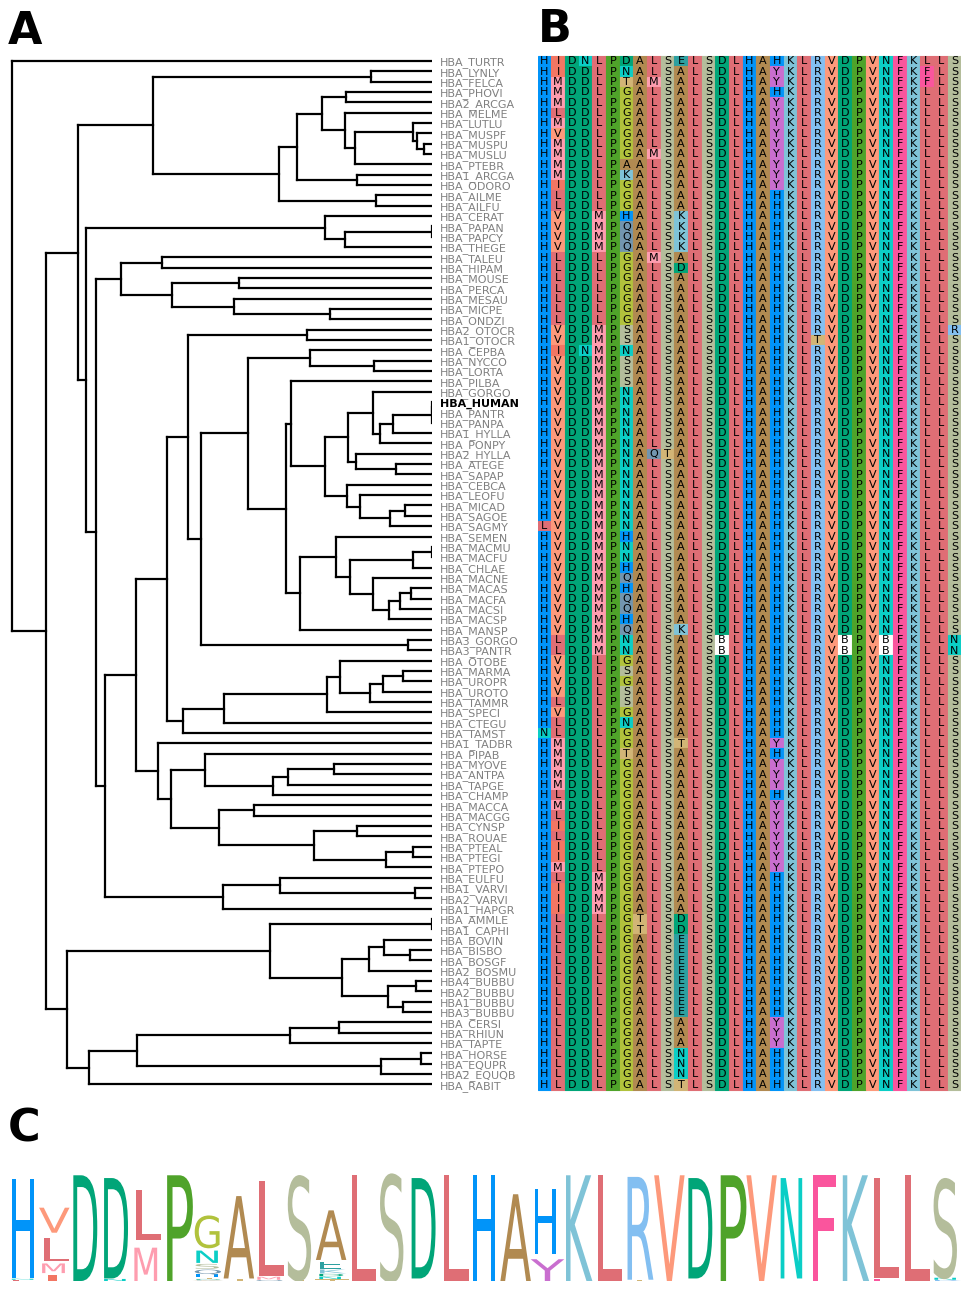

In [10]:
figure, axes = plt.subplot_mosaic(
    [
        ['tree', 'alignment'],
        ['logo', 'logo']
    ],
    figsize=(12.0,16.0),
    gridspec_kw=dict(height_ratios=[8, 1]),
    constrained_layout=True
)

graphics.plot_dendrogram(
    axes["tree"], tree, orientation="left",
    labels=[gene_names[ref_id] for ref_id in ordered_ref_ids],
    show_distance=False, linewidth=2
)
axes["tree"].tick_params(bottom=False)
axes["tree"].set_title("A", loc="left", size=40, weight="semibold")
# Hihlight human variant with bold label
for label in axes["tree"].get_yticklabels():
    if label.get_text() == "HBA_HUMAN":
        label.set_fontweight("semibold")
    else:
        label.set_color("gray")

graphics.plot_alignment_type_based(
    axes["alignment"], subalignment[:, alignment_order[::-1]],
    color_scheme="flower", symbols_per_line=len(subalignment),
)
# Adapt vertical limit to align both subfigures
axes["alignment"].set_ylim(len(alignment_order) + 0.5, -0.5)
axes["alignment"].set_title("B", loc="left", size=40, weight="semibold")

graphics.plot_sequence_logo(axes["logo"], profile, scheme="flower")
# Remove spines
axes["logo"].axis("off")
axes["logo"].set_title("C", loc="left", size=40, weight="bold")

plt.show()